In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_damped_pendulum_data, get_damped_SHM_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance, get_damped_polynomial_invariance
from damped_invariance_kernel import SHMEpsilonMean, PendulumEpsilonMean, PolynomialEpsilonMean
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [2]:

class SHMLatentInvariance(gpflow.kernels.Kernel):
    def __init__(self, invariance_range, invar_density, jitter_size):
        super().__init__(active_dims=[0, 1])
        self.Ka = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kv = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kz = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.jitter = jitter_size
        invariance_xs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_vs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_xx, invariance_vv = tf.meshgrid(invariance_xs, invariance_vs)
        self.invar_grids = tf.stack([tf.reshape(invariance_xx,[-1]), tf.reshape(invariance_vv,[-1])], axis=1)
        self.x_g_squared = tf.tensordot(self.invar_grids[:,0,None],self.invar_grids[None,:,0],1)
        self.x_g_dot_squared = tf.tensordot(self.invar_grids[:,1,None],self.invar_grids[None,:,1],1)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        n = X.shape[0]
        m = X2.shape[0]

        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        zeros_nm =tf.zeros((n,m), dtype=tf.float64)
        zeros_mm =tf.zeros((m,m), dtype=tf.float64)
        
        Ka_X1X1  = self.Ka(X) 
        Kv_X1X1  = self.Kv(X) 
        Kz_X1X1  = self.Kz(X) 
        K_X1X1   = tf.concat([tf.concat([Ka_X1X1,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X1X1,zeros_nn],1),tf.concat([zeros_nn,zeros_nn, Kz_X1X1],1)],0)

        Ka_X1X2  = self.Ka(X, X2) 
        Kv_X1X2  = self.Kv(X, X2) 
        Kz_X1X2  = self.Kz(X, X2) 
        K_X1X2   = tf.concat([tf.concat([Ka_X1X2,zeros_nm, zeros_nm],1),tf.concat([zeros_nm, Kv_X1X2, zeros_nm],1),tf.concat([zeros_nm, zeros_nm, Kz_X1X2],1)],0)
        
        K_X2X1   = tf.transpose(K_X1X2)
        
        Ka_X2X2  = self.Ka(X2) 
        Kv_X2X2  = self.Kv(X2) 
        Kz_X2X2  = self.Kz(X2) 
        K_X2X2   = tf.concat([tf.concat([Ka_X2X2,zeros_mm, zeros_mm],1),tf.concat([zeros_mm,Kv_X2X2, zeros_mm],1),tf.concat([zeros_mm, zeros_mm, Kz_X2X2],1)],0)
        
        Ka_X1Xg  = self.Ka(X, self.invar_grids) 
        Kv_X1Xg  = self.Kv(X, self.invar_grids) 
        Kz_X1Xg  = self.Kz(X, self.invar_grids) 
        K_X1Xg = tf.concat([Ka_X1Xg, Kv_X1Xg, Kz_X1Xg],0)

        Ka_X2Xg =  self.Ka(X2, self.invar_grids) 
        Kv_X2Xg =  self.Kv(X2, self.invar_grids)
        Kz_X2Xg  = self.Kz(X2, self.invar_grids) 
        K_X2Xg = tf.concat([Ka_X2Xg, Kv_X2Xg, Kz_X2Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g_1 = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,0]
        x_g_dot_1 = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_1 = tf.ones([n, x_g_1.shape[1]], dtype=tf.float64) 
        x_g_1_stacked = tf.concat([x_g_dot_1, x_g_1, z_g_1],0)
        
        x_g_2 = tf.ones([m, 1], dtype=tf.float64) * self.invar_grids[:,0]
        x_g_dot_2 = tf.ones([m, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_2 = tf.ones([m, x_g_2.shape[1]], dtype=tf.float64) 
        x_g_2_stacked = tf.concat([x_g_dot_2, x_g_2, z_g_2],0)
        
        A = tf.concat([tf.concat([K_X1X1, K_X1X2],1),tf.concat([K_X2X1, K_X2X2],1)],0) 
        B1 = tf.multiply(K_X1Xg, x_g_1_stacked)
        B2 = tf.multiply(K_X2Xg, x_g_2_stacked)
        B = tf.concat([B1, B2], 0)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg 
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        return (A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D), 1), C, 1))[:2*n, 3*n:(3*n+2*m)]

    def K_diag(self, X):
        n = X.shape[0]
        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        
        Ka_X  = self.Ka(X) 
        Kv_X  = self.Kv(X) 
        Kz_X  = self.Kz(X)
        K_X   = tf.concat([tf.concat([Ka_X,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X, zeros_nn],1),tf.concat([zeros_nn, zeros_nn, Kz_X],1)],0)
        
        Ka_Xg  = self.Ka(X, self.invar_grids) 
        Kv_Xg  = self.Kv(X, self.invar_grids) 
        Kz_Xg  = self.Kz(X, self.invar_grids) 
        K_Xg = tf.concat([Ka_Xg, Kv_Xg, Kz_Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,0]
        x_g_dot = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g = tf.ones([n, x_g.shape[1]],dtype=tf.float64)
        x_g_stacked = tf.concat([x_g_dot, x_g, z_g],0)
        
        A = K_X
        B = tf.multiply(K_Xg, x_g_stacked)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        
        return tf.linalg.tensor_diag_part((A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D),1), C, 1))[:2*n,:2*n])

In [3]:

class PendulumLatentInvariance(gpflow.kernels.Kernel):
    def __init__(self, invariance_range, invar_density, jitter_size):
        super().__init__(active_dims=[0, 1])
        self.jitter = jitter_size
        self.Ka = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kv = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kz = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 

        invariance_xs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_vs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_xx, invariance_vv = tf.meshgrid(invariance_xs, invariance_vs)
        self.invar_grids = tf.stack([tf.reshape(invariance_xx,[-1]), tf.reshape(invariance_vv,[-1])], axis=1)

        self.x_g_squared = tf.tensordot(tf.math.sin(self.invar_grids[:,0,None]),tf.math.sin(self.invar_grids[None,:,0]),1)
        self.x_g_dot_squared = tf.tensordot(self.invar_grids[:,1,None],self.invar_grids[None,:,1],1)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        n = X.shape[0]
        m = X2.shape[0]

        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        zeros_nm =tf.zeros((n,m), dtype=tf.float64)
        zeros_mm =tf.zeros((m,m), dtype=tf.float64)
        
        Ka_X1X1  = self.Ka(X) 
        Kv_X1X1  = self.Kv(X) 
        Kz_X1X1  = self.Kz(X) 
        K_X1X1   = tf.concat([tf.concat([Ka_X1X1,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X1X1,zeros_nn],1),tf.concat([zeros_nn,zeros_nn, Kz_X1X1],1)],0)

        Ka_X1X2  = self.Ka(X, X2) 
        Kv_X1X2  = self.Kv(X, X2) 
        Kz_X1X2  = self.Kz(X, X2) 
        K_X1X2   = tf.concat([tf.concat([Ka_X1X2,zeros_nm, zeros_nm],1),tf.concat([zeros_nm, Kv_X1X2, zeros_nm],1),tf.concat([zeros_nm, zeros_nm, Kz_X1X2],1)],0)
        
        K_X2X1   = tf.transpose(K_X1X2)
        
        Ka_X2X2  = self.Ka(X2) 
        Kv_X2X2  = self.Kv(X2) 
        Kz_X2X2  = self.Kz(X2) 
        K_X2X2   = tf.concat([tf.concat([Ka_X2X2,zeros_mm, zeros_mm],1),tf.concat([zeros_mm,Kv_X2X2, zeros_mm],1),tf.concat([zeros_mm, zeros_mm, Kz_X2X2],1)],0)
        
        Ka_X1Xg  = self.Ka(X, self.invar_grids) 
        Kv_X1Xg  = self.Kv(X, self.invar_grids) 
        Kz_X1Xg  = self.Kz(X, self.invar_grids) 
        K_X1Xg = tf.concat([Ka_X1Xg, Kv_X1Xg, Kz_X1Xg],0)

        Ka_X2Xg =  self.Ka(X2, self.invar_grids) 
        Kv_X2Xg =  self.Kv(X2, self.invar_grids)
        Kz_X2Xg  = self.Kz(X2, self.invar_grids) 
        K_X2Xg = tf.concat([Ka_X2Xg, Kv_X2Xg, Kz_X2Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g_1 = tf.ones([n, 1], dtype=tf.float64) * tf.math.sin(self.invar_grids[:,0])
        x_g_dot_1 = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_1 = tf.ones([n, x_g_1.shape[1]], dtype=tf.float64) 
        x_g_1_stacked = tf.concat([x_g_dot_1, x_g_1, z_g_1],0)
        
        x_g_2 = tf.ones([m, 1], dtype=tf.float64) * tf.math.sin(self.invar_grids[:,0])
        x_g_dot_2 = tf.ones([m, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g_2 = tf.ones([m, x_g_2.shape[1]], dtype=tf.float64) 
        x_g_2_stacked = tf.concat([x_g_dot_2, x_g_2, z_g_2],0)

        
        A = tf.concat([tf.concat([K_X1X1, K_X1X2],1),tf.concat([K_X2X1, K_X2X2],1)],0) 
        B1 = tf.multiply(K_X1Xg, x_g_1_stacked)
        B2 = tf.multiply(K_X2Xg, x_g_2_stacked)
        B = tf.concat([B1, B2], 0)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg 
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        return (A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D), 1), C, 1))[:2*n, 3*n:(3*n+2*m)]

    def K_diag(self, X):
        n = X.shape[0]
        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        
        Ka_X  = self.Ka(X) 
        Kv_X  = self.Kv(X) 
        Kz_X  = self.Kz(X)
        K_X   = tf.concat([tf.concat([Ka_X,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X, zeros_nn],1),tf.concat([zeros_nn, zeros_nn, Kz_X],1)],0)
        
        Ka_Xg  = self.Ka(X, self.invar_grids) 
        Kv_Xg  = self.Kv(X, self.invar_grids) 
        Kz_Xg  = self.Kz(X, self.invar_grids) 
        K_Xg = tf.concat([Ka_Xg, Kv_Xg, Kz_Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g = tf.ones([n, 1], dtype=tf.float64) * tf.math.sin(self.invar_grids[:,0])
        x_g_dot = tf.ones([n, 1], dtype=tf.float64) * self.invar_grids[:,1]
        z_g = tf.ones([n, x_g.shape[1]],dtype=tf.float64)
        x_g_stacked = tf.concat([x_g_dot, x_g, z_g],0)
        
        A = K_X
        B = tf.multiply(K_Xg, x_g_stacked)
        C = tf.transpose(B)
        D = tf.multiply(self.x_g_dot_squared, Ka_XgXg) + tf.multiply(self.x_g_squared, Kv_XgXg) + Kz_XgXg
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        
        return tf.linalg.tensor_diag_part((A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D),1), C, 1))[:2*n,:2*n])

In [4]:

class PolynomialLatentInvariance(gpflow.kernels.Kernel):
    def __init__(self, invariance_range, invar_density, jitter_size, poly_f_d, poly_g_d):
        super().__init__(active_dims=[0,1])
        self.poly_f_d = poly_f_d
        self.poly_g_d = poly_g_d
        self.prior_variance = 0.1#gpflow.Parameter(0.1, transform=positive())#tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(1.)))
        self.f_poly = gpflow.Parameter(tf.Variable(1e-3*np.random.normal(size=(self.poly_f_d,1)), dtype=tf.float64), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), prior=tfp.distributions.Laplace(to_default_float(0),to_default_float(self.prior_variance)), name="f_poly")
        self.g_poly = gpflow.Parameter(tf.Variable(1e-3*np.random.normal(size=(self.poly_g_d,1)), dtype=tf.float64), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), prior=tfp.distributions.Laplace(to_default_float(0),to_default_float(self.prior_variance)), name="g_poly")

        self.jitter =jitter_size
        self.Ka = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kv = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        self.Kz = gpflow.kernels.RBF(variance=1, lengthscales=[1,1]) 
        invariance_xs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_vs = tf.linspace(-invariance_range,invariance_range,invar_density)
        invariance_xx, invariance_vv = tf.meshgrid(invariance_xs, invariance_vs)
        self.invar_grids = tf.stack([tf.reshape(invariance_xx,[-1]), tf.reshape(invariance_vv,[-1])], axis=1)

    def inv_f(self, X):
        return tf.linalg.matmul(tf.math.pow(X, list(range(self.poly_f_d))), self.f_poly)
    def inv_g(self, X):
        return tf.linalg.matmul(tf.math.pow(X, list(range(self.poly_g_d))), self.g_poly)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        n = X.shape[0]
        m = X2.shape[0]

        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        zeros_nm =tf.zeros((n,m), dtype=tf.float64)
        zeros_mm =tf.zeros((m,m), dtype=tf.float64)
        
        Ka_X1X1  = self.Ka(X) 
        Kv_X1X1  = self.Kv(X) 
        Kz_X1X1  = self.Kz(X) 
        K_X1X1   = tf.concat([tf.concat([Ka_X1X1,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X1X1,zeros_nn],1),tf.concat([zeros_nn,zeros_nn, Kz_X1X1],1)],0)

        Ka_X1X2  = self.Ka(X, X2) 
        Kv_X1X2  = self.Kv(X, X2) 
        Kz_X1X2  = self.Kz(X, X2) 
        K_X1X2   = tf.concat([tf.concat([Ka_X1X2,zeros_nm, zeros_nm],1),tf.concat([zeros_nm, Kv_X1X2, zeros_nm],1),tf.concat([zeros_nm, zeros_nm, Kz_X1X2],1)],0)
        
        K_X2X1   = tf.transpose(K_X1X2)
        
        Ka_X2X2  = self.Ka(X2) 
        Kv_X2X2  = self.Kv(X2) 
        Kz_X2X2  = self.Kz(X2) 
        K_X2X2   = tf.concat([tf.concat([Ka_X2X2,zeros_mm, zeros_mm],1),tf.concat([zeros_mm,Kv_X2X2, zeros_mm],1),tf.concat([zeros_mm, zeros_mm, Kz_X2X2],1)],0)
        
        Ka_X1Xg  = self.Ka(X, self.invar_grids) 
        Kv_X1Xg  = self.Kv(X, self.invar_grids) 
        Kz_X1Xg  = self.Kz(X, self.invar_grids) 
        K_X1Xg = tf.concat([Ka_X1Xg, Kv_X1Xg, Kz_X1Xg],0)

        Ka_X2Xg =  self.Ka(X2, self.invar_grids) 
        Kv_X2Xg =  self.Kv(X2, self.invar_grids)
        Kz_X2Xg  = self.Kz(X2, self.invar_grids) 
        K_X2Xg = tf.concat([Ka_X2Xg, Kv_X2Xg, Kz_X2Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g_1 = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_g(self.invar_grids[:,0, None]))
        x_g_dot_1 = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_f(self.invar_grids[:,1, None]))
        z_g_1 = tf.ones([n, x_g_1.shape[1]], dtype=tf.float64) 
        x_g_1_stacked = tf.concat([x_g_dot_1, x_g_1, z_g_1],0)
        
        x_g_2 = tf.ones([m, 1], dtype=tf.float64) * tf.squeeze(self.inv_g(self.invar_grids[:,0, None]))
        x_g_dot_2 = tf.ones([m, 1], dtype=tf.float64) * tf.squeeze(self.inv_f(self.invar_grids[:,1, None]))
        z_g_2 = tf.ones([m, x_g_2.shape[1]], dtype=tf.float64) 
        x_g_2_stacked = tf.concat([x_g_dot_2, x_g_2, z_g_2],0)

        x_g_squared = tf.tensordot(self.inv_g(self.invar_grids[:,0,None]),tf.transpose(self.inv_g(self.invar_grids[:,0, None])),1)
        x_g_dot_squared = tf.tensordot(self.inv_f(self.invar_grids[:,1,None]),tf.transpose(self.inv_f(self.invar_grids[:,1, None])),1)
        
        A = tf.concat([tf.concat([K_X1X1, K_X1X2],1),tf.concat([K_X2X1, K_X2X2],1)],0) 
        B1 = tf.multiply(K_X1Xg, x_g_1_stacked)
        B2 = tf.multiply(K_X2Xg, x_g_2_stacked)
        B = tf.concat([B1, B2], 0)
        C = tf.transpose(B)

        D = tf.multiply(x_g_dot_squared, Ka_XgXg) + tf.multiply(x_g_squared, Kv_XgXg) + Kz_XgXg 
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        return (A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D), 1), C, 1))[:2*n, 3*n:(3*n+2*m)]

    def K_diag(self, X):
        n = X.shape[0]
        zeros_nn =tf.zeros((n,n), dtype=tf.float64)
        
        Ka_X  = self.Ka(X) 
        Kv_X  = self.Kv(X) 
        Kz_X  = self.Kz(X)
        K_X   = tf.concat([tf.concat([Ka_X,zeros_nn, zeros_nn],1),tf.concat([zeros_nn,Kv_X, zeros_nn],1),tf.concat([zeros_nn, zeros_nn, Kz_X],1)],0)
        
        Ka_Xg  = self.Ka(X, self.invar_grids) 
        Kv_Xg  = self.Kv(X, self.invar_grids) 
        Kz_Xg  = self.Kz(X, self.invar_grids) 
        K_Xg = tf.concat([Ka_Xg, Kv_Xg, Kz_Xg],0)

        Ka_XgXg = self.Ka(self.invar_grids) 
        Kv_XgXg = self.Kv(self.invar_grids) 
        Kz_XgXg = self.Kz(self.invar_grids) 
        
        x_g = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_g(self.invar_grids[:,0, None]))
        x_g_dot = tf.ones([n, 1], dtype=tf.float64) * tf.squeeze(self.inv_f(self.invar_grids[:,1, None]))
        z_g = tf.ones([n, x_g.shape[1]],dtype=tf.float64)
        x_g_stacked = tf.concat([x_g_dot, x_g, z_g],0)
        
        x_g_squared = tf.tensordot(self.inv_g(self.invar_grids[:,0,None]),tf.transpose(self.inv_g(self.invar_grids[:,0, None])),1)
        x_g_dot_squared = tf.tensordot(self.inv_f(self.invar_grids[:,1,None]),tf.transpose(self.inv_f(self.invar_grids[:,1, None])),1)
        
        A = K_X
        B = tf.multiply(K_Xg, x_g_stacked)
        C = tf.transpose(B)
        D = tf.multiply(x_g_dot_squared, Ka_XgXg) + tf.multiply(x_g_squared, Kv_XgXg) + Kz_XgXg
        D += self.jitter*tf.eye(D.shape[0], dtype=tf.float64)
        
        return tf.linalg.tensor_diag_part((A-tf.tensordot(tf.tensordot(B, tf.linalg.inv(D),1), C, 1))[:2*n,:2*n])

In [5]:

def get_latent_polynomial_invariance(invar_range, invar_density, jitter_size, poly_f_d, poly_g_d):
    invariance_kernel = PolynomialLatentInvariance(invar_range, invar_density, jitter_size, poly_f_d, poly_g_d)
    invariance_kernel.Ka.variance = gpflow.Parameter(invariance_kernel.Ka.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.variance = gpflow.Parameter(invariance_kernel.Kv.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.variance = gpflow.Parameter(invariance_kernel.Kz.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Ka.lengthscales = gpflow.Parameter(invariance_kernel.Ka.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.lengthscales = gpflow.Parameter(invariance_kernel.Kv.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.lengthscales = gpflow.Parameter(invariance_kernel.Kz.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    return invariance_kernel

def get_latent_SHM_invariance(invar_range, invar_density, jitter_size):
    invariance_kernel = SHMLatentInvariance(invar_range, invar_density, jitter_size)
    invariance_kernel.Ka.variance = gpflow.Parameter(invariance_kernel.Ka.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.variance = gpflow.Parameter(invariance_kernel.Kv.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.variance = gpflow.Parameter(invariance_kernel.Kz.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Ka.lengthscales = gpflow.Parameter(invariance_kernel.Ka.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.lengthscales = gpflow.Parameter(invariance_kernel.Kv.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.lengthscales = gpflow.Parameter(invariance_kernel.Kz.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    return invariance_kernel

def get_latent_pendulum_invariance(invar_range, invar_density, jitter_size):
    invariance_kernel = PendulumLatentInvariance(invar_range, invar_density, jitter_size)
    invariance_kernel.Ka.variance = gpflow.Parameter(invariance_kernel.Ka.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.variance = gpflow.Parameter(invariance_kernel.Kv.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.variance = gpflow.Parameter(invariance_kernel.Kz.variance.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Ka.lengthscales = gpflow.Parameter(invariance_kernel.Ka.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kv.lengthscales = gpflow.Parameter(invariance_kernel.Kv.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    invariance_kernel.Kz.lengthscales = gpflow.Parameter(invariance_kernel.Kz.lengthscales.numpy(), transform=tfp.bijectors.Sigmoid(to_default_float(1e-3), to_default_float(10.))) 
    return invariance_kernel

In [50]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 3
max_v = 0.3
n_train = 5
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_SHM_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[-0.19561267  0.43396109  0.23585715  1.40215436 -1.31125025]
[-0.27557184  0.06415656 -0.25868174 -0.11246658 -0.03955333]


In [71]:

moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 5e-5
invar_density = 40
latex=""
kernel = get_latent_SHM_invariance(3, invar_density, jitter) #switch
known = get_GPR_model(kernel, mean, data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
i = 0
for poly_f_d in [2]:
    for poly_g_d in [2]:
        kernel = get_latent_polynomial_invariance(3, invar_density, jitter, poly_f_d, poly_g_d) #switch
        m = get_GPR_model(kernel, mean, data, 3000)
        print("learnt: "+format(m.log_marginal_likelihood().numpy(),".2f"))

moi:408.00
known: 430.17
learnt: 422.52


In [72]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.f_poly,Parameter,Sigmoid,Laplace,True,"(2, 1)",float64,[[-0.00332416] [ 0.92120623]]
GPR.kernel.g_poly,Parameter,Sigmoid,Laplace,True,"(2, 1)",float64,[[6.94565615e-04] [9.10206170e-01]]
GPR.kernel.Ka.variance,Parameter,Sigmoid,,True,(),float64,9.982431382821245
GPR.kernel.Ka.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[0.87788939 4.83361863]
GPR.kernel.Kv.variance,Parameter,Sigmoid,,True,(),float64,9.518022223015924
GPR.kernel.Kv.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.99766608 5.38927734]
GPR.kernel.Kz.variance,Parameter,Sigmoid,,True,(),float64,9.992977945399014
GPR.kernel.Kz.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.98569743 4.07121553]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0009021613545196e-06


In [73]:
known

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Ka.variance,Parameter,Sigmoid,,True,(),float64,9.959603323405801
GPR.kernel.Ka.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[8.15752726 1.34054851]
GPR.kernel.Kv.variance,Parameter,Sigmoid,,True,(),float64,8.665415298133368
GPR.kernel.Kv.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.47049417 2.3237761 ]
GPR.kernel.Kz.variance,Parameter,Sigmoid,,True,(),float64,0.0026895879977371457
GPR.kernel.Kz.lengthscales,Parameter,Sigmoid,,True,"(2,)",float64,[9.9983966 0.29420255]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000004513017028e-06


In [74]:
eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

grids = (3, 40)
dynamics = damped_SHM_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = m.log_marginal_likelihood().numpy()

#grid_moi = (evaluate_model_grid(moi, grids, dynamics))
#grid_inv = (evaluate_model_grid(known, grids, dynamics))
#grid_inv_p = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)
#print(lml_inv_p)
#def energy(X):
#    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])
def energy(X):
    return 0.5*tf.square(X[:,1])+0.5*tf.square(X[:,0])

for i in range(5):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])


407.9954277667938
430.16854073184874
0
0.3111588626957854g
0.04950283425505041gg
0.020229429602306465g
1
3.268775293651442ng
0.589819975771423nggg
0.021590834114876164g
2
0.0012377335973617575
0.006037151886185847g
0.008931134390885402g
3
4.045188508884149ng
0.804523795022107nggg
0.019104173653970356g
4
0.0370832355929229g
0.010634790945924476g
0.014240549653033495g


In [75]:
print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") +' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

Log Marginal Likelihood & 408.00 & 430.17 & 422.52 \\
MSE & 1.5327 & 0.2921 & 0.0168 \\


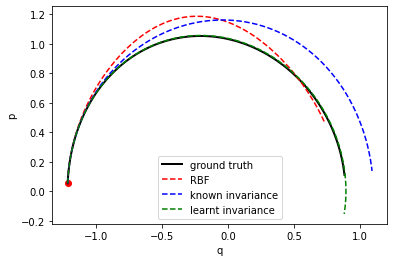

In [76]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
#plt.savefig("figures/shm_predicted.pdf")

Text(0, 0.5, 'E')

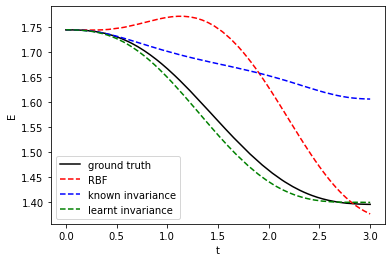

In [77]:

t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="ground truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_energy.pdf")